# Book Recommendation

## 1. Set up the environment

In [ ]:
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Download Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# Unzip the file
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
# Set up the enviornment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.2.1-bin-hadoop3.2'
# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark
# Import a Spark function from library
from pyspark.sql.functions import col

In [ ]:
# basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data  spark-3.2.1-bin-hadoop3.2  spark-3.2.1-bin-hadoop3.2.tgz


## 2. Import the data
<font color='red'>MAKE SURE that the tables should be uploaded under `/sample_data/Book_Recommendation`!!!</font><br>
The data comes from https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?select=Ratings.csv

In [ ]:
os.chdir('/content/sample_data/Book_Recommendation')
os.listdir()

['recsys_taxonomy2.png', 'Ratings.csv', 'Users.csv', 'Books.csv']

Open the data

In [ ]:
book = spark.read.load('/content/sample_data/Book_Recommendation/Books.csv', header = True, format = 'csv')
user = spark.read.load('/content/sample_data/Book_Recommendation/Users.csv', header = True, format = 'csv')
rating = spark.read.load('/content/sample_data/Book_Recommendation/Ratings.csv', header = True, format = 'csv')

# the last one would persumed to be important, ... you know, user-book-rating as Recommendation input.

## 3. Data Exploration

In [ ]:
book.show(5)
# (ISBN, Book-Title, Book-Author, Year-Of-Publication, Publisher, Image-URL-S, Image-URL-M, Image-URL-L)
# count the row
print(book.count())

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|               2002|Oxford University...|http://images.ama...|http://images.ama...|http://images.ama...|
|0002005018|        Clara Callan|Richard Bruce Wright|               2001|HarperFlamingo Ca...|http://images.ama...|http://images.ama...|http://images.ama...|
|0060973129|Decision in Normandy|        Carlo D'Este|               1991|     HarperPerennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0374157065|Flu: The Story of...|    Gina Bari

In [ ]:
# https://sparkbyexample.com
# count N of not null value of each column
for column in book.columns:
  print(column, '\t', book.filter(col(column).isNull()).count())

# very few value is missing... Including Book-Author, Publisher, and Image-Url-L

ISBN 	 0
Book-Title 	 0
Book-Author 	 1
Year-Of-Publication 	 0
Publisher 	 2
Image-URL-S 	 0
Image-URL-M 	 0
Image-URL-L 	 3


In [ ]:
user.show(5)
# (User-ID, Location, Age)
print(user.count())

+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|      1|  nyc, new york, usa|null|
|      2|stockton, califor...|18.0|
|      3|moscow, yukon ter...|null|
|      4|porto, v.n.gaia, ...|17.0|
|      5|farnborough, hant...|null|
+-------+--------------------+----+
only showing top 5 rows

278859


In [ ]:
# check n of non-null value
for column in user.columns:
  print(column, '\t', user.filter(col(column).isNull()).count())
# one user-id is null, yet age ... nearly half of them are null...

User-ID 	 1
Location 	 0
Age 	 110518


In [ ]:
user.printSchema()
# Age should be changed into float...

root
 |-- User-ID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: integer (nullable = true)



In [ ]:
from pyspark.sql.types import IntegerType
user = user.withColumn('Age', col('Age').cast(IntegerType()))

In [ ]:
user.describe()

DataFrame[summary: string, User-ID: string, Location: string, Age: string]

It seems that there's some missing value in age, I am going to explore it a little bit later on.

In [ ]:
rating.show(5)
# (User-ID, ISBN, Book-Rating)
print(rating.count())

+-------+----------+-----------+
|User-ID|      ISBN|Book-Rating|
+-------+----------+-----------+
| 276725|034545104X|          0|
| 276726|0155061224|          5|
| 276727|0446520802|          0|
| 276729|052165615X|          3|
| 276729|0521795028|          6|
+-------+----------+-----------+
only showing top 5 rows

1149780


In [ ]:
# check null value
for column in rating.columns:
  print(column, '\t', rating.filter(col(column).isNull()).count())

# This critical form seems to be good...

User-ID 	 0
ISBN 	 0
Book-Rating 	 0


In [ ]:
from pyspark.sql.types import FloatType
rating = rating.withColumn('Book-Rating', col('Book-Rating').cast(FloatType()))

In [ ]:
rating.printSchema()

root
 |-- User-ID: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: float (nullable = true)



Create Sql View

In [ ]:
user.registerTempTable('user')
# (User-ID, Location, Age)
rating.registerTempTable('rating')
# (User-ID, ISBN, Book-Rating)
book.registerTempTable('book')
# (ISBN, Book-Title, Book-Author, Year-Of-Publication, Publisher, Image-URL-S, Image-URL-M, Image-URL-L)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


### Questions on describing this dataset

1. Books: How many books were published each year?

In [ ]:
# sql way
q1 = spark.sql('''
  select `Year-Of-Publication`, count(`book-title`)
  from
  book
  where `Year-Of-Publication` between -9999 and 9999
  group by 1
  order by 1
''')
q1.show()

+-------------------+-----------------+
|Year-Of-Publication|count(book-title)|
+-------------------+-----------------+
|               1961|                1|
|                  0|             4618|
|               1376|                1|
|               1378|                1|
|               1806|                1|
|               1897|                1|
|               1900|                3|
|               1901|                7|
|               1902|                2|
|               1904|                1|
|               1906|                1|
|               1908|                1|
|               1909|                2|
|               1910|                1|
|               1911|               19|
|               1914|                1|
|               1917|                1|
|               1919|                1|
|               1920|               33|
|               1921|                2|
+-------------------+-----------------+
only showing top 20 rows



In [ ]:
q1 = q1.toPandas()

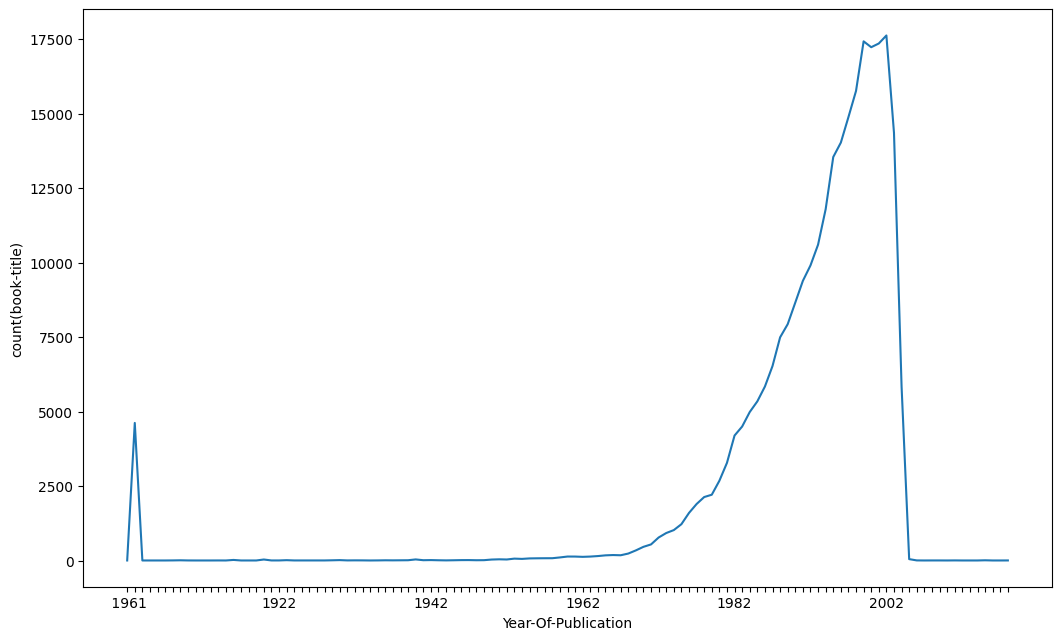

In [ ]:
plt.rcParams["figure.figsize"] = [12.50, 7.50]
plot = sns.lineplot(q1, x = 'Year-Of-Publication', y = 'count(book-title)')
for index, label in enumerate(plot.get_xticklabels()):
   if index % 20 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
plt.show()

The data is not clean though,,, yet we can see the increasement in number of publication after 1969

2. Books: How many books were published by each publisher? Which publisher produced most books according to the list? Which authors published their books in that publisher?


In [ ]:
# sql way
# number of books published by each publisher, who published most books
q2_1 = spark.sql('''
  select `Publisher`, count(`book-title`)
  from
  book
  group by 1
  order by 2 desc
''')
q2_1.show()
# harlequin is the publisher published most books

+--------------------+-----------------+
|           Publisher|count(book-title)|
+--------------------+-----------------+
|           Harlequin|             7533|
|          Silhouette|             4220|
|              Pocket|             3905|
|    Ballantine Books|             3782|
|        Bantam Books|             3645|
|          Scholastic|             3159|
|Simon &amp; Schuster|             2969|
|       Penguin Books|             2843|
|Berkley Publishin...|             2771|
|        Warner Books|             2727|
|         Penguin USA|             2717|
|       Harpercollins|             2524|
|       Fawcett Books|             2258|
|         Signet Book|             2070|
|    Random House Inc|             2044|
|       St Martins Pr|             1953|
|  St. Martin's Press|             1783|
|           Tor Books|             1704|
|HarperCollins Pub...|             1699|
|         Zebra Books|             1694|
+--------------------+-----------------+
only showing top

In [ ]:
# Which authors published their books in that publisher?
# q2_2 = spark.sql('''select `book-author` from book where publisher = 'Harlequin'
# ''')
q2_2 = spark.sql('''
  with best_publisher as (
    select `publisher` from (
      select `publisher`, count(*) as counts
      from book
      group by 1
      order by 2 desc
      limit 1
    )
  ) select `book-author` from book
  where publisher in (select publisher from best_publisher)
''')
q2_2.show()

+--------------------+
|         book-author|
+--------------------+
|     Georgette Heyer|
|     Rebecca Winters|
|Cathy Gillen Thacker|
|        Sandra Field|
|        Helen Brooks|
|        Mallory Rush|
|        Mollie Molay|
|    Carrie Alexander|
|      Lori Handeland|
|       Debra Salonen|
|     Rebecca Winters|
|        Margaret Way|
|      Marisa Carroll|
|        Julie Miller|
|   Stephanie Laurens|
|         Betty Neels|
|        Nora Roberts|
|        Janet Dailey|
|       Debra Salonen|
|        Fay Robinson|
+--------------------+
only showing top 20 rows



In [ ]:
# dataframe way
# number of books published by each publisher, who published most books
q2_1 = book.groupBy('Publisher').count().toPandas()
q2_1.sort_values('count', ascending = False)
# again, Harlequin is the most productive publisher

,Publisher,count
8876,Harlequin,7533
6820,Silhouette,4220
3984,Pocket,3905
6436,Ballantine Books,3782
1487,Bantam Books,3645
...,...,...
9068,River City Pub.,1
9069,American Eagle Publications,1
9070,Lambertus-Verlag,1
9078,Harri Deutsch,1


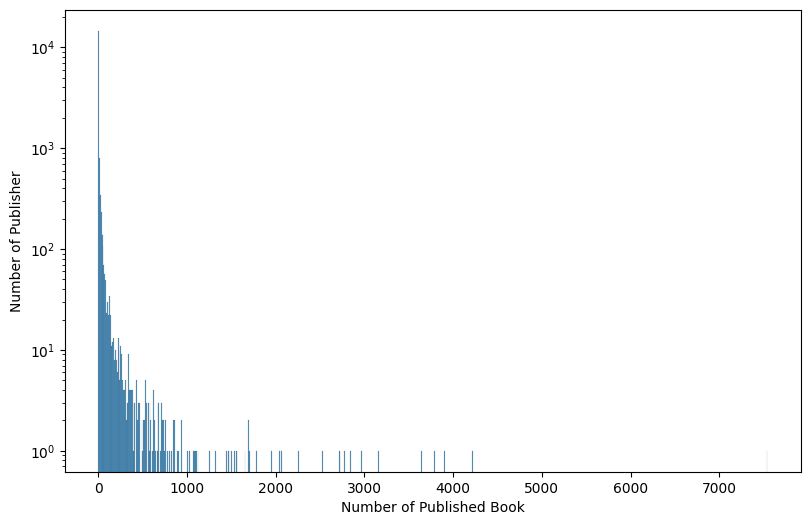

In [ ]:
plt.rcParams["figure.figsize"] = [9.50, 6.00]
cnt = q2_1['count']
g = sns.histplot(cnt, binwidth = 10)
g.set_yscale("log")
_ = g.set(xlabel="Number of Published Book", ylabel="Number of Publisher") # https://stackoverflow.com/questions/27019153/how-to-scale-seaborns-y-axis-with-a-bar-plot
# Most of them are not productive though

In [ ]:
q2_2 = book.filter(book.Publisher == "Harlequin").select('Book-Author')
q2_2.show()
q2_2.count() # 7533 authors were choosing harlequin as their publisher

+--------------------+
|         Book-Author|
+--------------------+
|     Georgette Heyer|
|     Rebecca Winters|
|Cathy Gillen Thacker|
|        Sandra Field|
|        Helen Brooks|
|        Mallory Rush|
|        Mollie Molay|
|    Carrie Alexander|
|      Lori Handeland|
|       Debra Salonen|
|     Rebecca Winters|
|        Margaret Way|
|      Marisa Carroll|
|        Julie Miller|
|   Stephanie Laurens|
|         Betty Neels|
|        Nora Roberts|
|        Janet Dailey|
|       Debra Salonen|
|        Fay Robinson|
+--------------------+
only showing top 20 rows



7533

3. Books: The distribution of the book published by each publisher.

In [ ]:
# sql way
q3 = spark.sql('''
  select publisher, count(*)
  from book
  group by 1
''')
q3.show()

+--------------------+--------+
|           publisher|count(1)|
+--------------------+--------+
|Harper Mass Marke...|    1450|
|Editiones B, Grup...|       1|
|      Celestial Arts|     114|
|    Adams Media Corp|      36|
|Chicago Review Press|      39|
|Carroll &amp; Gra...|     375|
|Ullstein-Taschenb...|      30|
|Lucis Publishing ...|       1|
|        Lorenz Books|      47|
|           LPC Group|      12|
|Faith Publishing ...|       4|
|Ediciones Alfagua...|       8|
|         Cleis Press|      36|
|    Underwood-Miller|       3|
|    Daughters, inc.]|       1|
|                 DAW|       3|
|              Paidos|       1|
| A. &amp; M. Muchnik|       1|
|       No Exit Press|       5|
|Scribes Valley Pu...|       1|
+--------------------+--------+
only showing top 20 rows



In [ ]:
# dataframe way
q3 = book.groupBy('Publisher').count().toPandas()['count']

The average publisher have published 16 books, and the median of such a number is 1. 
The number of publishing ranges between 1 and 7533.


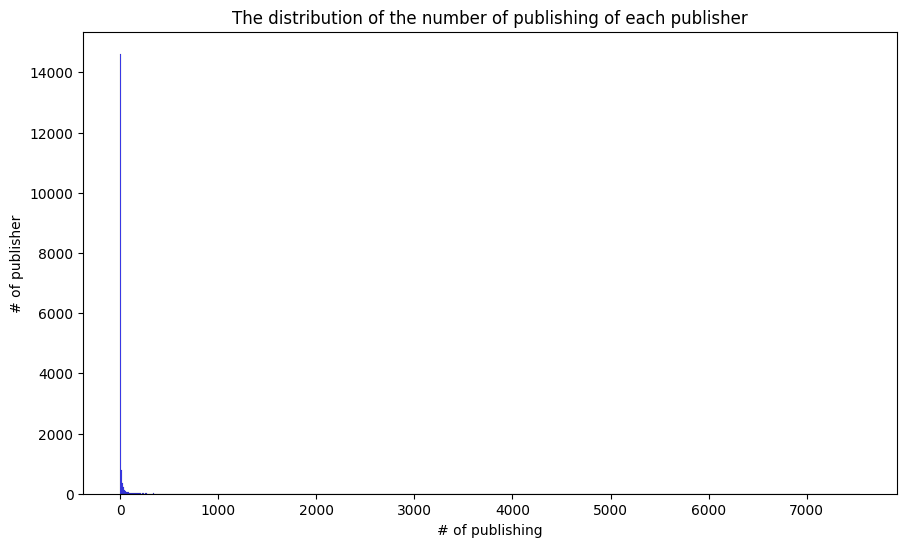

In [ ]:
med = q3.median()
avg = q3.mean()
mins = q3.min()
maxs = q3.max()

plt.rcParams["figure.figsize"] = [10.50, 6.00]
g = sns.histplot(q3, color = 'blue', binwidth = 10)
_ = g.set(title = 'The distribution of the number of publishing of each publisher', xlabel = '# of publishing', ylabel = '# of publisher')
print(f'The average publisher have published {round(avg)} books, and the median of such a number is \
{round(med)}. \nThe number of publishing ranges between {mins} and {maxs}.')

4. Books: Is all of the information provided by AMAZON?

In [ ]:
# sql way: to see if amazon is in their corresponding url
q4 = spark.sql('''
  select * from
  book
  where `image-url-m` not like '%amazon%' and
  `image-url-l` not like '%amazon%'
''')
q4.show()
q4.count()

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------------+
|      ISBN|          Book-Title|         Book-Author| Year-Of-Publication|           Publisher|         Image-URL-S|  Image-URL-M|        Image-URL-L|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------------+
|1853670383|"King of Air Figh...|                V.C.|              D.S.O.| M.C. (Vintage Av...|           No 21)"""|    Ira Jones|               1989|
|378460529X|"Hundert Gedichte...|  \"" \""RÃ¼ckenwind|\"" \""Drachenste...|\"" und ein Gespr...|        Sarah Kirsch|         1985|Langewiesche-Brandt|
|3251004050|"\Mind-boggling""...|    some other stuff| acht unpaginiert...| etliche s/w-Abbi...| sowie Zeichnunge...|    Max Goldt|               1998|
|0413497607|Moliere: Five Pla...|      \""Tartuffe\""| \""The School fo...|     \""The M

7

In [ ]:
# dataframe way
q4 = book.filter(~col('Image-Url-M').contains('amazon') & ~col('Image-Url-L').contains('amazon'))
q4.show()
q4.count()
# it seems that the data is not clean though... Fortunately, there are only 7 records having such a problem

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------------+
|      ISBN|          Book-Title|         Book-Author| Year-Of-Publication|           Publisher|         Image-URL-S|  Image-URL-M|        Image-URL-L|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------------+
|1853670383|"King of Air Figh...|                V.C.|              D.S.O.| M.C. (Vintage Av...|           No 21)"""|    Ira Jones|               1989|
|378460529X|"Hundert Gedichte...|  \"" \""RÃ¼ckenwind|\"" \""Drachenste...|\"" und ein Gespr...|        Sarah Kirsch|         1985|Langewiesche-Brandt|
|3251004050|"\Mind-boggling""...|    some other stuff| acht unpaginiert...| etliche s/w-Abbi...| sowie Zeichnunge...|    Max Goldt|               1998|
|0413497607|Moliere: Five Pla...|      \""Tartuffe\""| \""The School fo...|     \""The M

7

Almost all data derived from amazon, with quite few data omitting the corresponding url.<br>
Therefore, we can safely assume that nearly all the information is derived from AMAZON.

5. User: How many people did not provide their age?


In [ ]:
# sql way
q5 = spark.sql('''
  select * from user
  where age is null
''')
q5.show()

+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|      1|  nyc, new york, usa|null|
|      3|moscow, yukon ter...|null|
|      5|farnborough, hant...|null|
|      7| washington, dc, usa|null|
|      8|timmins, ontario,...|null|
|      9|germantown, tenne...|null|
|     12|fort bragg, calif...|null|
|     14|mediapolis, iowa,...|null|
|     15|calgary, alberta,...|null|
|     16|albuquerque, new ...|null|
|     17|chesapeake, virgi...|null|
|     22|erfurt, thueringe...|null|
|     23|philadelphia, pen...|null|
|     26|bellevue, washing...|null|
|     32|portland, oregon,...|null|
|     34|london, england, ...|null|
|     39|cary, north carol...|null|
|     43|méxico, méxico ci...|null|
|     45|berlin, n/a, germany|null|
|     48|chicago, illinois...|null|
+-------+--------------------+----+
only showing top 20 rows



In [ ]:
# the proportion of such a problem
q5_2 = spark.sql('''
  with age_null as (
    select count(*) as count_null
    from user where age is null
  ),
  all_record as (select count(*) as totals from user)
  select count_null/totals from age_null, all_record
''')
q5_2.show()

+---------------------+
|(count_null / totals)|
+---------------------+
|   0.3987140454494924|
+---------------------+



In [ ]:
# dataframe way
q5 = user.filter(col('Age').isNull()).count()
print(f'There are {q5} people did not provide their age, accounting to {round(q5/user.count() * 100, 2)}% of all.')

There are 111185 people did not provide their age, accounting to 39.87% of all.


6. User: The average age of the reader? Min age? Max age? And their distribution?


In [ ]:
# sql way
q6 = spark.sql('''
  select round(avg(age),2) as average_age, min(age) as min_age, max(age) as max_age from user
''')
q6.show()
# seems that some have provided the false information on the internet...

+-----------+-------+-------+
|average_age|min_age|max_age|
+-----------+-------+-------+
|      34.75|      0|    244|
+-----------+-------+-------+



In [ ]:
# dataframe way
q6 = user.select('Age').toPandas()
mean = q6.mean()['Age']
mins = q6.min()['Age']
maxs = q6.max()['Age']
medians = q6.median()['Age']
qtle1 = q6.quantile(0.25)['Age']
qtle3 = q6.quantile(0.75)['Age']

The user age is between 0.0 and 244.0, with the average user age as 34.8, and the median (Q25, Q75) of such a number is 32 (24.0, 44.0).


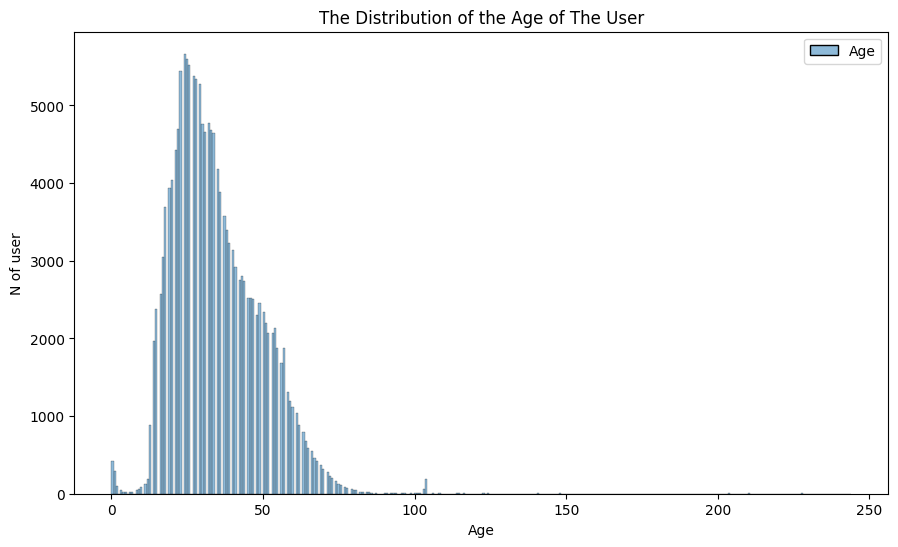

In [ ]:
plt.rcParams["figure.figsize"] = [10.50, 6.00]
g = sns.histplot(q6, color = 'blue')
_ = g.set(title = 'The Distribution of the Age of The User', xlabel = 'Age', ylabel = 'N of user')
print(f'The user age is between {mins} and {maxs}, with the average user age as {round(mean, 1)}, and the median (Q25, Q75) of such a number is \
{round(medians)} ({qtle1}, {qtle3}).')

<font color = 'red'>Therefore, data cleaning is required if we use age as input feature...</font>Although most user provided their relatively true data.

7. User: How many user are in Canada? Which book do they usually read?


In [ ]:
# sql way
# how many Canadian user
q7_1 = spark.sql('''
  select count(*) from
  user
  where
  location like '%canada%' or
  location like '%Canada%'
''')
q7_1.show()

+--------+
|count(1)|
+--------+
|   21678|
+--------+



In [ ]:
q7_2 = spark.sql('''
  with canadian_user as (
    select `user-id` from
    user
    where
    location like '%canada%' or
    location like '%Canada%'
  )
  select distinct `book-title` from
  rating join book on rating.ISBN = book.ISBN
  join user on rating.`user-id` = user.`user-id`
  where user.`user-id` in (
    select `user-id` from canadian_user
  )
''')
q7_2.show()
q7_2.count()

+--------------------+
|          book-title|
+--------------------+
|   A Calculated Risk|
|  Tangled Up in Blue|
|           OBSESSION|
|       Screen kisses|
|           Amaryllis|
|Lie Down With Lio...|
|             CONTACT|
|Iced (Regan Reill...|
|The Wizard's Holi...|
|Nasty Nature (Hor...|
|Too Many Men : A ...|
|Money, Money, Mon...|
|                Nell|
|Best Friends Wear...|
|        Johnny Angel|
|The Haunted House...|
|     The Way of Love|
|  Fran Ellen's House|
|    One Police Plaza|
|Sams Teach Yourse...|
+--------------------+
only showing top 20 rows



50346

There are 21678 users from Canada, reading 50346 books.

8. User-Book: Which book does those between 25 and 35-year-olds read?


In [ ]:
# sql way
q8 = spark.sql('''
  select distinct `book-title` from
  rating full join user on rating.`user-id` = user.`user-id`
  full join book on rating.ISBN = book.ISBN
  where
  age between 25 and 35
''')
q8.show()
q8.count()

+--------------------+
|          book-title|
+--------------------+
|Seven Years In Tibet|
|Five Photos of My...|
|Prophecies: 4,000...|
|              Apt. 3|
|Too Many Men : A ...|
|What Do Women Wan...|
|Emily Post's Wedd...|
| Why Do You Love Me?|
|Series of Unfortu...|
|After Lucy : A Novel|
|             Nemesis|
|To Catch a Cook :...|
|     Trading Reality|
|Heart of the Country|
|The Highland clea...|
|The broom of the ...|
|Last White Man in...|
|Tortoise by Candl...|
|Pride and Prejudi...|
|The Communist Man...|
+--------------------+
only showing top 20 rows



106408

In [ ]:
# top 5 books that Millennials read
q8_2 = spark.sql('''
  select `book-title`, count(*) from
  rating full join user on rating.`user-id` = user.`user-id`
  full join book on rating.ISBN = book.ISBN
  where
  age between 25 and 35 and `book-title` is not null
  group by 1
  order by 2 desc
  limit 5
''')
q8_2.show()

+--------------------+--------+
|          book-title|count(1)|
+--------------------+--------+
|         Wild Animus|     796|
|The Lovely Bones:...|     357|
|Bridget Jones's D...|     291|
|   The Da Vinci Code|     275|
|The Nanny Diaries...|     265|
+--------------------+--------+



The Millennials containing most readers are reading 106408 different books, notably as *Wild Animus*, *The Lovely Bones: ...*, *Bridget Jones's D...*, *The Da Vinci Code*, and *The Nanny Diaries...*.

9. User-Book: Mean Age & the distribution of age of the reader who read the book from the publisher that published the most book.


In [ ]:
# sql way
# all ages: mean age should select avg(age) instead
q9 = spark.sql('''
  select avg(age) as mean_age, min(age) as min_age, max(age) as max_age from (
    select distinct rating.`User-id`, Age from
    rating join user on rating.`user-id` = user.`user-id`
    join book on rating.ISBN = book.ISBN
    where publisher in (
      select `publisher` from (
        select `publisher`, count(*) as counts
        from book
        group by 1
        order by 2 desc
        limit 1
        )
    )
  )
''')
q9.show()

+-----------------+-------+-------+
|         mean_age|min_age|max_age|
+-----------------+-------+-------+
|36.43307593307593|      0|    228|
+-----------------+-------+-------+



In [ ]:
# dataframe way
# the publisher that published the most book
most_productive_publisher = book.groupBy('Publisher')\
  .count().toPandas().sort_values('count', ascending = False).iloc[0,0]
most_productive_publisher

# https://stackoverflow.com/questions/40343625/joining-spark-dataframes-on-the-key
# https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.DataFrame.join.html
# https://stackoverflow.com/questions/30248221/removing-duplicates-from-rows-based-on-specific-columns-in-an-rdd-spark-datafram
q9 = user.join(rating, 'User-ID', 'inner').join(book, 'ISBN', 'inner')\
  .filter(col('Publisher') == most_productive_publisher).dropDuplicates(['User-ID']).select('Age')
q9.show(5)

+----+
| Age|
+----+
|null|
|  30|
|  33|
|  29|
|null|
+----+
only showing top 5 rows



The user age is between 0.0 and 228.0, with the average user age as 36.4, and the median (Q25, Q75) of such a number is 34 (24.0, 44.0).


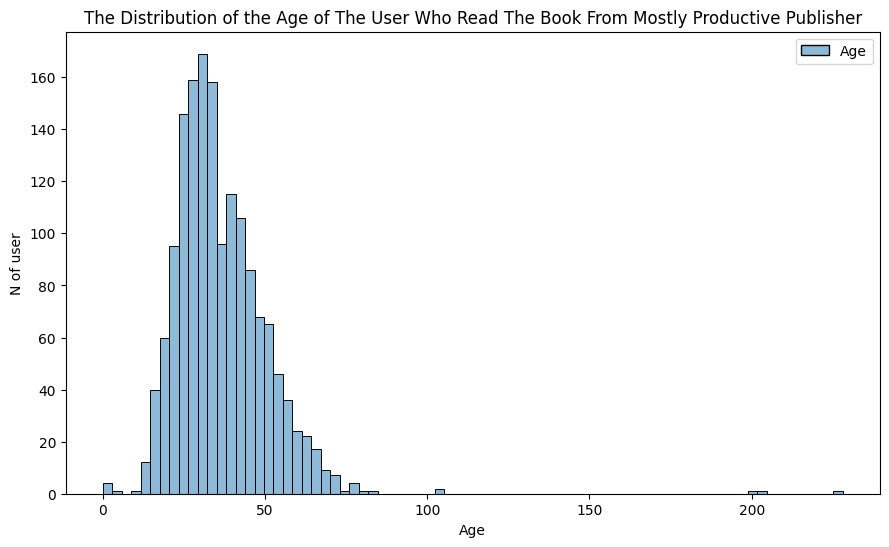

In [ ]:
q9 = q9.toPandas()

means = q9.mean()['Age']
medians = q9.median()['Age']
mins = q9.min()['Age']
maxs = q9.max()['Age']
qtile1 = q9.quantile(0.25)['Age']
qtile3 = q9.quantile(0.75)['Age']

plt.rcParams["figure.figsize"] = [10.50, 6.00]
g = sns.histplot(q9, color = 'blue')
_ = g.set(title = 'The Distribution of the Age of The User Who Read The Book From Mostly Productive Publisher', xlabel = 'Age', ylabel = 'N of user')
print(f'The user age is between {mins} and {maxs}, with the average user age as {round(means, 1)}, and the median (Q25, Q75) of such a number is \
{round(medians)} ({qtle1}, {qtle3}).')

Tends to be a little older comparing to general population. However, t-test might be required.

10. Rating: The distribution of the frequency of rating by user.


In [ ]:
# sql way
q10 = spark.sql('''
  select min(count) as min_freq, max(count) as max_freq, avg(count) as average_freq from (
    select `user-id`, count(*) as count from
    rating
    group by 1
  )
''')
q10.show()

+--------+--------+------------------+
|min_freq|max_freq|      average_freq|
+--------+--------+------------------+
|       1|   13602|10.920851419507423|
+--------+--------+------------------+



The user usually rate between 1.0 and 4.0 times based on this database, 
with the minimum time as 1 and maximum time as 13602.
The median frequency is 1.0


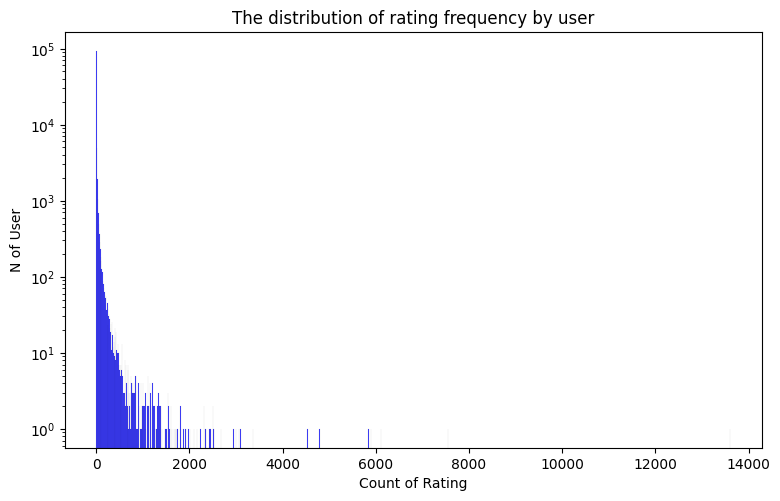

In [ ]:
# dataframe way
q10 = rating.groupBy('User-Id').count().toPandas()['count']

min = q10.min()
max = q10.max()
median = q10.median()
qtile1 = q10.quantile(0.25)
qtile3 = q10.quantile(0.75)


plt.rcParams["figure.figsize"] = (9,5.4)
p = sns.histplot(q10, color = 'blue', binwidth = 10)
p.set_yscale('log')
_ = p.set(title = 'The distribution of rating frequency by user', xlabel = 'Count of Rating', ylabel = 'N of User')

print(f'The user usually rate between {qtile1} and {qtile3} times based on this database, \nwith the minimum time as {min} and maximum time as {max}.\n\
The median frequency is {median}')

In [ ]:
rating.groupBy('User-Id').count().toPandas().sort_values('count', ascending = False)

,User-Id,count
31598,11676,13602
72304,198711,7550
6546,153662,6109
42538,98391,5891
49881,35859,5850
...,...,...
44682,18213,1
44681,17158,1
44678,15149,1
44677,14216,1


There are very few top commentor here...

11. Rating: The distribution of the frequency of rating by book. Which book shares the most rating?


In [ ]:
# sql way
# distribution
q11_1 = spark.sql('''
  select ISBN, count(*) from rating
  group by 1
  order by 2 desc
''')
q11_1.show()

+----------+--------+
|      ISBN|count(1)|
+----------+--------+
|0971880107|    2502|
|0316666343|    1295|
|0385504209|     883|
|0060928336|     732|
|0312195516|     723|
|044023722X|     647|
|0679781587|     639|
|0142001740|     615|
|067976402X|     614|
|0671027360|     586|
|0446672211|     585|
|059035342X|     571|
|0316601950|     568|
|0375727345|     552|
|044021145X|     529|
|0452282152|     526|
|0440214041|     523|
|0804106304|     519|
|0440211727|     517|
|0345337662|     506|
+----------+--------+
only showing top 20 rows



In [ ]:
# find the title of the book that received most rate
q11_2 = spark.sql('''
  select distinct `book-title` from
  rating join book on rating.ISBN = book.ISBN
  where rating.ISBN in (
    select ISBN from (
      select ISBN, count(*) from
      rating
      group by 1
      order by 2 desc
      limit 1
    )
  )
''')
q11_2.show()

+-----------+
| book-title|
+-----------+
|Wild Animus|
+-----------+



In [ ]:
# dataframe way
# Find the most rated book
q11_1 = rating.groupBy('ISBN').count().join(book, 'ISBN', 'inner')\
  .toPandas().sort_values('count', ascending = False)['Book-Title'].iloc[0]
q11_1

'Wild Animus'

So, the book received most times of rating was *Wild Animus*.

For each book, the median (Q25, Q75) of the time of rating is 1.0 (1.0, 3.0)
The least rated book received 1 rate, while the most rated book received 2502 times.


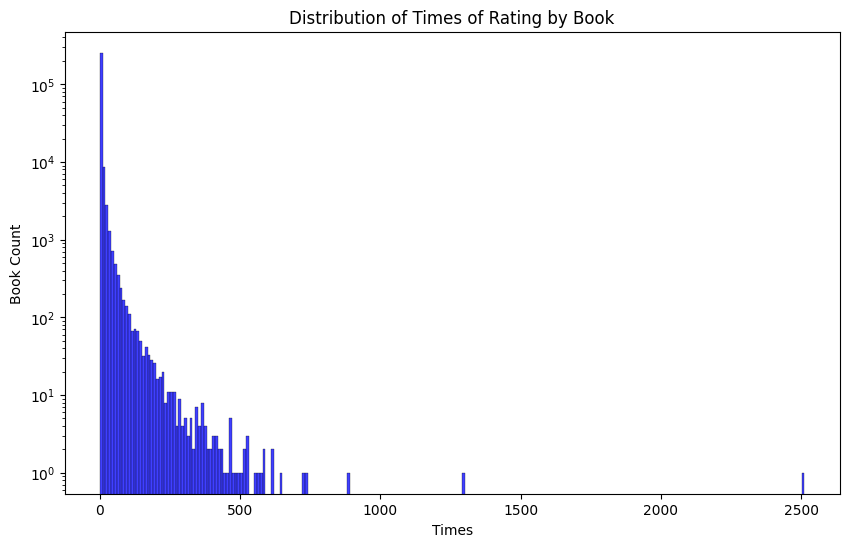

In [ ]:
# distribution of rating
rating_distribution = rating.groupBy('ISBN').count().join(book, 'ISBN', 'inner')\
  .toPandas().sort_values('count', ascending = False)['count']

mins = rating_distribution.min()
max = rating_distribution.max()
median = rating_distribution.median()

qtile1 = rating_distribution.quantile(0.25)
qtile3 = rating_distribution.quantile(0.75)

plt.rcParams['figure.figsize'] = (10, 6)
p = sns.histplot(rating_distribution, binwidth = 10, color = 'blue')
_ = p.set(title = 'Distribution of Times of Rating by Book', xlabel = 'Times', ylabel = 'Book Count')
p.set_yscale('log')
print(f'For each book, the median (Q25, Q75) of the time of rating is {median} ({qtile1}, {qtile3})')
print(f'The least rated book received {mins} rate, while the most rated book received {max} times.')

*Wild Animus* Received most times of rating (2502 times).

12. Rating: The distribution of 1) the overall rating score? 2) The avg score by each user? 3) The avg score by book?


In [ ]:
# sql way
# overall rating score and distribution
q12_1 = spark.sql('''
  select avg(`book-rating`) as average_rating_score, min(`book-rating`) as min_rating_score, max(`book-rating`) as max_rating_score
  from rating
''')
q12_1.show()

+--------------------+----------------+----------------+
|average_rating_score|min_rating_score|max_rating_score|
+--------------------+----------------+----------------+
|  2.8669501991685364|             0.0|            10.0|
+--------------------+----------------+----------------+



In [ ]:
# avg score by each user
q12_2 = spark.sql('''
  select `user-id`, avg(`book-rating`)
  from rating
  group by 1
  order by 2 desc
''')
q12_2.show()

+-------+----------------+
|user-id|avg(book-rating)|
+-------+----------------+
|  55498|            10.0|
| 161799|            10.0|
| 124709|            10.0|
| 164433|            10.0|
| 131033|            10.0|
| 145723|            10.0|
| 278659|            10.0|
| 163768|            10.0|
|  32812|            10.0|
|    125|            10.0|
|  77814|            10.0|
|  41009|            10.0|
|  83461|            10.0|
| 103368|            10.0|
| 112464|            10.0|
|  51946|            10.0|
| 136186|            10.0|
|  54097|            10.0|
| 149687|            10.0|
|  56814|            10.0|
+-------+----------------+
only showing top 20 rows



In [ ]:
# avg score by book
q12_3 = spark.sql('''
select ISBN, avg(`book-rating`)
from rating
group by 1
order by 2 desc
''')
q12_3.show()

+----------+----------------+
|      ISBN|avg(book-rating)|
+----------+----------------+
|1576903389|            10.0|
|0945367198|            10.0|
|0140256725|            10.0|
|9707100567|            10.0|
|0094770506|            10.0|
|3190032947|            10.0|
|067088782X|            10.0|
|0822022311|            10.0|
|0859051595|            10.0|
|0439577527|            10.0|
|0690041535|            10.0|
|0785108904|            10.0|
|1586851578|            10.0|
|0300044194|            10.0|
|156987512X|            10.0|
|0374522685|            10.0|
|0425105156|            10.0|
|0140350705|            10.0|
|0394731271|            10.0|
|0499220605|            10.0|
+----------+----------------+
only showing top 20 rows



The rating score is between 0.0 and 10.0, with the average score as 2.866950273513794
The Median (Q25, Q75) of the score is 0.0 (0.0, 7.0)


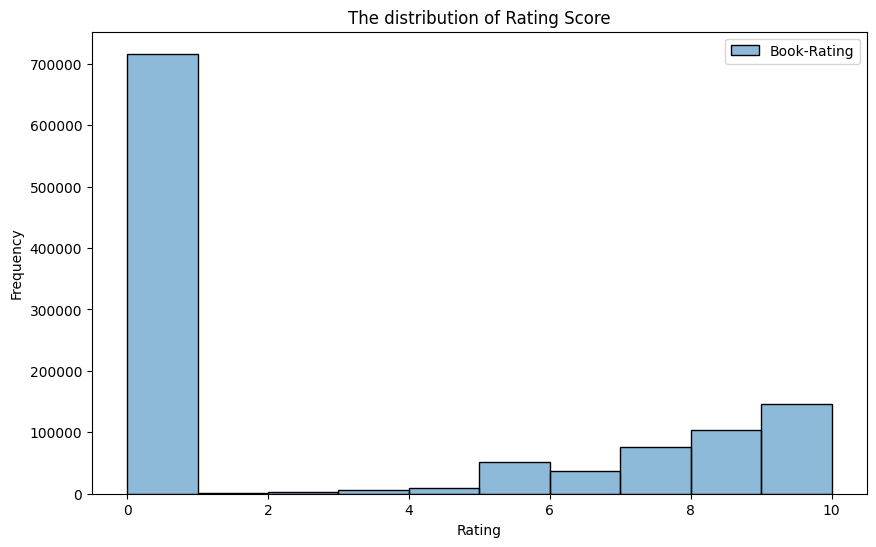

In [ ]:
# dataframe way
# q12_1 the distribution of the overall rating score
q12_1 = rating.select('Book-Rating').toPandas()

# descriptive statistics
mins = q12_1.min()['Book-Rating']
maxs = q12_1.max()['Book-Rating']
avg = q12_1.mean()['Book-Rating']
medians = q12_1.median()['Book-Rating']

qtile_1 = q12_1.quantile(0.25)['Book-Rating']
qtile_3 = q12_1.quantile(0.75)['Book-Rating']

# visulization
plt.rcParams['figure.figsize'] = (10, 6)
p = sns.histplot(q12_1, color = 'Blue', binwidth = 1)
_ = p.set(title = 'The distribution of Rating Score', xlabel = 'Rating', ylabel = 'Frequency')

print(f'The rating score is between {mins} and {maxs}, with the average score as {avg}')
print(f'The Median (Q25, Q75) of the score is {medians} ({qtile_1}, {qtile_3})')

Why many 0-point rating, is that means LITERALLY very few of them like reading???

The average rating score rages from 0.0 to 10.0, with the median (Q25, Q75) being 4.6 (0.0, 7.5)



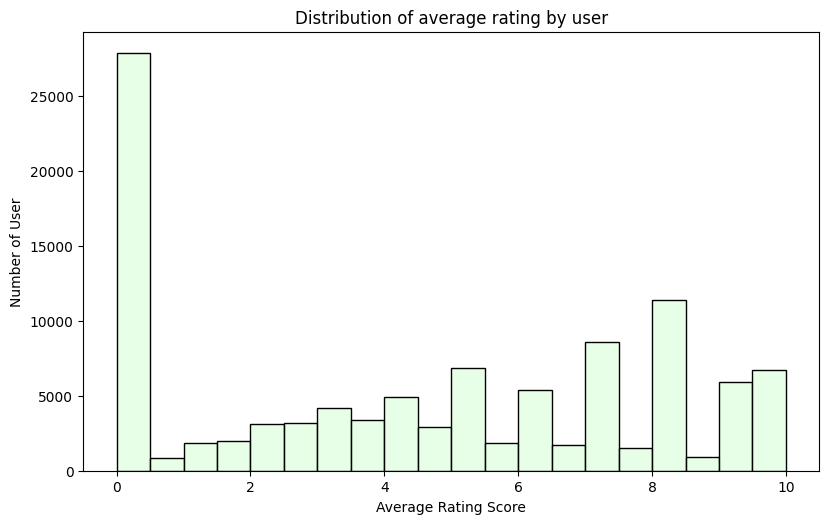

In [ ]:
# 2) The avg score by each user?
q12_2 = rating.groupBy('User-ID').mean('Book-Rating').toPandas()['avg(Book-Rating)']

# descriptive statistics, it is not meaningful to calculate the avg of the aggegated values...
mins = q12_2.min()
maxs = q12_2.max()
# avg = q12_2.mean()
medians = q12_2.median()
qtile_1 = q12_2.quantile(0.25)
qtile_3 = q12_2.quantile(0.75)

# visulization
plt.rcParams['figure.figsize'] = (9.5, 5.7)
p = sns.histplot(q12_2, binwidth = 0.5, color = '#DFFFDF')
_ = p.set(title = 'Distribution of average rating by user', xlabel = 'Average Rating Score', ylabel = 'Number of User')

print(f'The average rating score rages from {mins} to {maxs}, with the median (Q25, Q75) being {medians} ({qtile_1}, {qtile_3})')

Ah, quite a few readers almost rate 0 score only...

The average score received by each book ranges from 0.0 to 10.0, with the median (Q25, Q75) 
as 1.8 (0.0, 5.0)


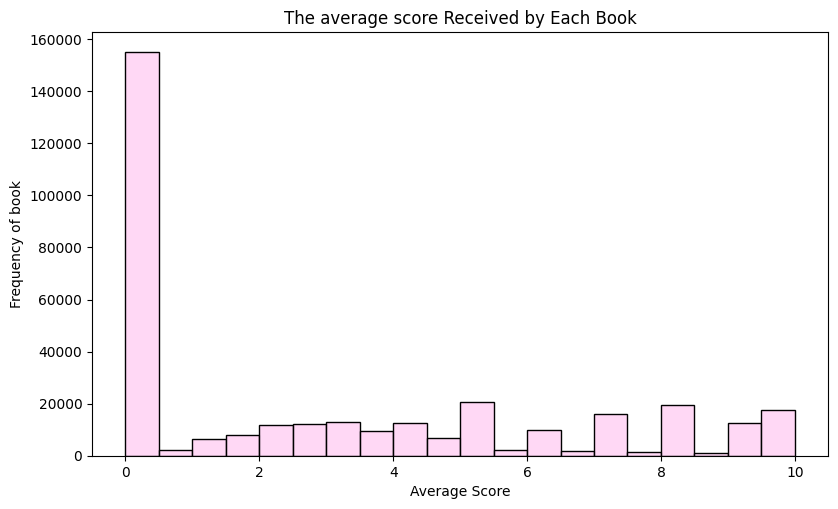

In [ ]:
# 3) The avg score by book?
q12_3 = rating.groupBy('ISBN').mean('Book-Rating').toPandas()['avg(Book-Rating)']

# descriptive, it is not meaningful to calculate the avg of the aggegated values...
mins = q12_3.min()
maxs = q12_3.max()
medians = q12_3.median()
qtile_1 = q12_3.quantile(0.25)
qtile_3 = q12_3.quantile(0.75)

# visulization
plt.rcParams['figure.figsize'] = (9.5, 5.5)
q = sns.histplot(q12_3, binwidth = 0.5, color = (1, 0.8, 0.95))
_ = q.set(title = 'The average score Received by Each Book', xlabel = 'Average Score', ylabel = 'Frequency of book')

# conclusion
print(f'The average score received by each book ranges from {mins} to {maxs}, with the median (Q25, Q75) \nas {medians} ({qtile_1}, {qtile_3})')

Most book received terrible feedback...

13. Rating: The most popular book(s)?(title required)


In [ ]:
# sql way
q13 = spark.sql('''
  with avgs as (
    select `Book-Title`, avg(`Book-Rating`) as averages from
    rating join book on
    rating.ISBN = book.ISBN
    group by 1)
  select `Book-Title`, averages from avgs where
  averages = (select max(averages) from avgs)

''')
q13.show()
q13.count()

+--------------------+--------+
|          Book-Title|averages|
+--------------------+--------+
|       Heart At Work|    10.0|
|Queen of Spades a...|    10.0|
|Good Morning, Kik...|    10.0|
|Daughter of Troy:...|    10.0|
|Bruce Springsteen...|    10.0|
|Calvin and Hobbes...|    10.0|
|Complete Law Scho...|    10.0|
|The power of the ...|    10.0|
|   Interactive Novel|    10.0|
|The Story of Jump...|    10.0|
|Quest for the Wes...|    10.0|
|Death of a Thousa...|    10.0|
|Peterson's Gradua...|    10.0|
|A Place of Greate...|    10.0|
|Loose Lips : A Novel|    10.0|
|Word Dance: The L...|    10.0|
|Lonely Planet Man...|    10.0|
|The Tibetan Book ...|    10.0|
|Ring Around the S...|    10.0|
|The Scent of Rose...|    10.0|
+--------------------+--------+
only showing top 20 rows



11760

In [ ]:
# dataframe way
max_avg_rating = rating.groupBy('ISBN').mean('Book-Rating').toPandas()['avg(Book-Rating)'].max()
q13 = rating.groupBy('ISBN').mean('Book-Rating').filter(col('avg(Book-Rating)') == max_avg_rating).\
  join(book, 'ISBN', 'inner').select(['Book-Title', 'avg(Book-Rating)'])
q13.show()
q13.count()

+--------------------+----------------+
|          Book-Title|avg(Book-Rating)|
+--------------------+----------------+
|       Babe Dressing|            10.0|
|Little Wolf's Boo...|            10.0|
|          Mr. Wright|            10.0|
|National Parks of...|            10.0|
|Seashore (Collins...|            10.0|
|The Piano Man's D...|            10.0|
|Come Through Marj...|            10.0|
|Expression of the...|            10.0|
|Steel Bonnets: Th...|            10.0|
|Watercolour Maste...|            10.0|
|Gardens in Waterc...|            10.0|
|  The Complete Works|            10.0|
|Collins Gem Wild ...|            10.0|
|Complete Works of...|            10.0|
|Complete Works of...|            10.0|
|Collins Bible Han...|            10.0|
|      The BLACK MOON|            10.0|
|The Sacrament of ...|            10.0|
|            Firewing|            10.0|
|Escape from the B...|            10.0|
+--------------------+----------------+
only showing top 20 rows



13112

Good to have so many books received full-mark rating. But why is it that the result is different between sql way and dataframe way?

14. Rating-User: The median rating score by canadian user?


In [ ]:
# sql way


In [ ]:
# dataframe way
q14 = user.filter(col('Location').like('%canada%') | col('Location').like('%Canada%')).\
  join(rating, 'User-ID', 'outer').groupBy('User-ID').mean('Book-Rating').toPandas()['avg(Book-Rating)'].\
  median()
q14

4.6

The median rating score is 4.6, identical to the entire population.

15. Rating-User: The average rating score distribution by age, any correlations?


In [ ]:
# sql way


In [ ]:
# dataframe way
# average rating by age group
# https://saturncloud.io/blog/how-to-groupcategorize-ages-column-in-python-pandas/#:~:text=We%20can%20create%20age%20groups,to%20group%20the%20data%20into.&text=Here%2C%20we%20have%20created%20six%20age%20groups%20using%20the%20pd.
q15_1 = user.join(rating, 'User-ID', 'outer').groupBy('Age').mean('Book-Rating').toPandas()

# bins = [0, 15, 25, 35, 45, 55, 65, 300]
# labels = ['0-15', '15-25', '25-35', '35-45', '45-55', '55-65', '65+']
# q15_1['Age Group'] = q15_1.cut(q15_1['Age'], bins=bins, labels=labels)
# q15_1.head()
q15_1.head()

,Age,avg(Book-Rating)
0,148.0,1.355556
1,31.0,2.730113
2,85.0,3.894737
3,65.0,1.793605
4,53.0,2.915708


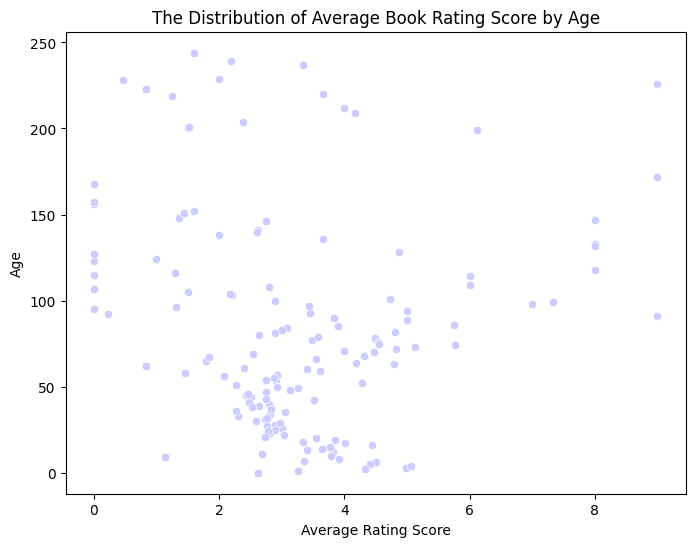

In [ ]:
# visulization
plt.rcParams['figure.figsize'] = (8, 6)
q = sns.scatterplot(q15_1, y = 'Age', x = 'avg(Book-Rating)', color = (0.8, 0.8, 1.0))
_ = q.set(title = 'The Distribution of Average Book Rating Score by Age',\
          xlabel = 'Average Rating Score', ylabel = 'Age')

In [ ]:
# dataframe way
# correlation
q15_2 = user.join(rating, 'User-ID', 'outer').toPandas()[['Age','Book-Rating']]
q15_2.corr()

,Age,Book-Rating
Age,1.000000,-0.028268
Book-Rating,-0.028268,1.000000


It seems that the age has almost no correlation to Book-Rating (slightly negative correlation)

16. The correlation between number of rating and the avg rating score.


In [ ]:
# sql way


,count,avg(Book-Rating)
count,1.000000,-0.006219
avg(Book-Rating),-0.006219,1.000000


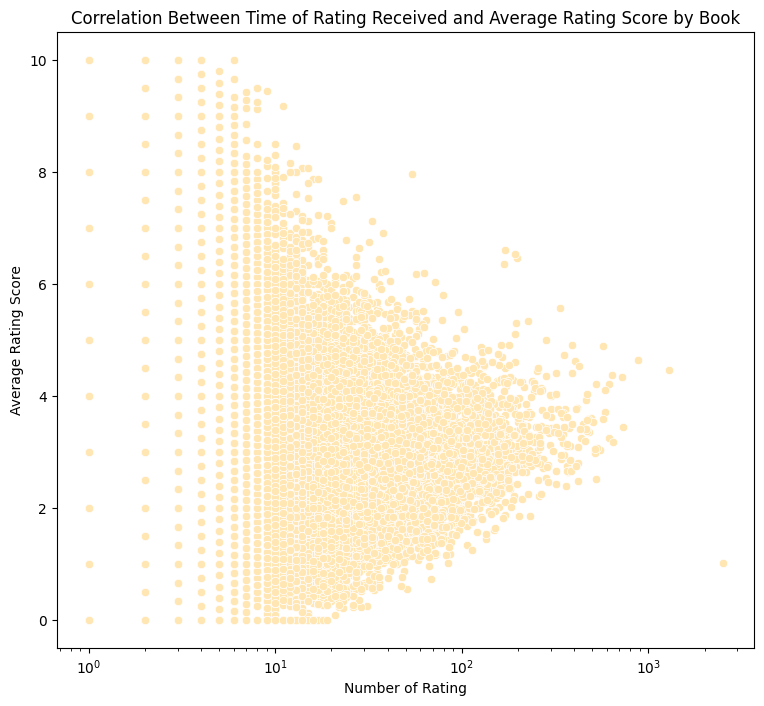

In [ ]:
# dataframe way
# correlation between # of rating and avg rate score by book
n_of_rating = rating.groupBy('ISBN').count()
avg_rating_score = rating.groupBy('ISBN').mean('Book-Rating')

q16 = n_of_rating.join(avg_rating_score, 'ISBN', 'inner').toPandas()[['count','avg(Book-Rating)']]

# visulization
plt.rcParams['figure.figsize'] = (9, 8)
q = sns.scatterplot(q16, x = 'count', y = 'avg(Book-Rating)', color = (1, 0.9, 0.7))
_ = q.set(title = 'Correlation Between Time of Rating Received and Average Rating Score by Book', \
          xlabel = 'Number of Rating', ylabel = 'Average Rating Score')
q.set_xscale('log')
q16.corr()

Seemingly there's no significant correlation between Number of Rating and Average Rating Score in terms of each book. However, we could see that many of most rated books are received mediocrete-low feedback from reader.

,count,avg(Book-Rating)
count,1.000000,-0.053982
avg(Book-Rating),-0.053982,1.000000


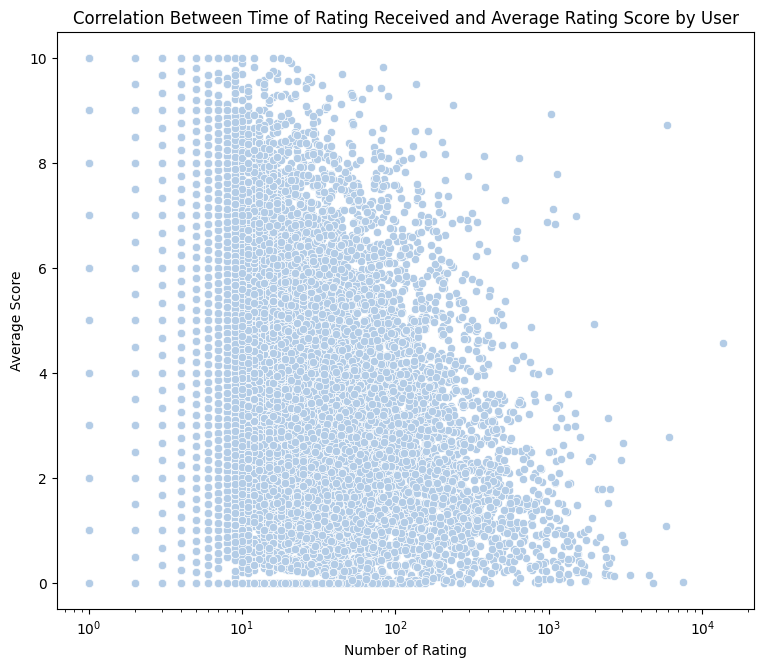

In [ ]:
# By user
n_of_rating_by_user = rating.groupBy('User-ID').count()
avg_rating_per_user = rating.groupBy('User-ID').mean('Book-Rating')
q16_2 = n_of_rating_by_user.join(avg_rating_per_user, 'User-ID', 'inner').toPandas()[['count', 'avg(Book-Rating)']]

# visulization & correlation
plt.rcParams['figure.figsize'] = (9,7.5)
p = sns.scatterplot(q16_2, x = 'count', y = 'avg(Book-Rating)', color = (0.7, 0.8, 0.9))
_ = p.set(title = 'Correlation Between Time of Rating Received and Average Rating Score by User',\
          xlabel = 'Number of Rating', ylabel = 'Average Score')
p.set_xscale('log')

q16_2.corr()

There's a very slight negative correlation between number of user rating and average score that the user has rated. Indicating that many user tend to rate the book due to the dissatisfaction and/or critics.

17. Rating-Book: The rating score distribution of the most productive publisher & (A bit difficult) The correlation between the avg rating score and the number of publishing for each publisher.

In [ ]:
# sql way


The distribution of the rating score for the most productive publisher ranges
 between 0.0 and 10.0. With the average score being 1.4393285512924194
The median (Q25, Q75) of the rating score is 0.0 (0.0, 0.0)


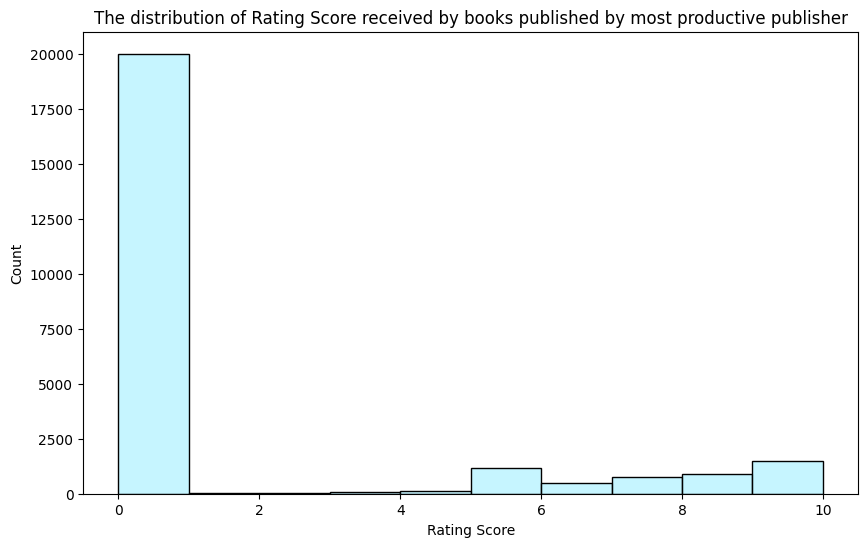

In [ ]:
# dataframe way
# The rating score distribution of the most productive publisher
most_productive_publisher = book.groupBy('Publisher').count().toPandas().\
  sort_values('count', ascending = False).iloc[0,0]

q17 = user.join(rating, 'User-ID', 'inner').join(book, 'ISBN', 'inner').\
  filter(col('Publisher') == most_productive_publisher).dropDuplicates().select('Book-Rating').\
  toPandas()['Book-Rating']

# aggregation
mins = q17.min()
maxs = q17.max()
means = q17.mean()
medians = q17.median()
qtile_1 = q17.quantile(0.25)
qtile_3 = q17.quantile(0.75)

# visulization
plt.rcParams['figure.figsize'] = (10, 6)
p = sns.histplot(q17, binwidth = 1, color = (0.7, 0.95, 1))
_ = p.set(title = 'The distribution of Rating Score received by books published by most productive publisher'\
          , xlabel = 'Rating Score', ylabel = 'Count')


# Summarization
print(f'The distribution of the rating score for the most productive publisher ranges\n between {mins} and {maxs}. With the average score being {means}')
print(f'The median (Q25, Q75) of the rating score is {medians} ({qtile_1}, {qtile_3})')

The book from the most productive publisher seems to be not so welecomed at all...

,avg(Book-Rating),count
avg(Book-Rating),1.000000,-0.020734
count,-0.020734,1.000000


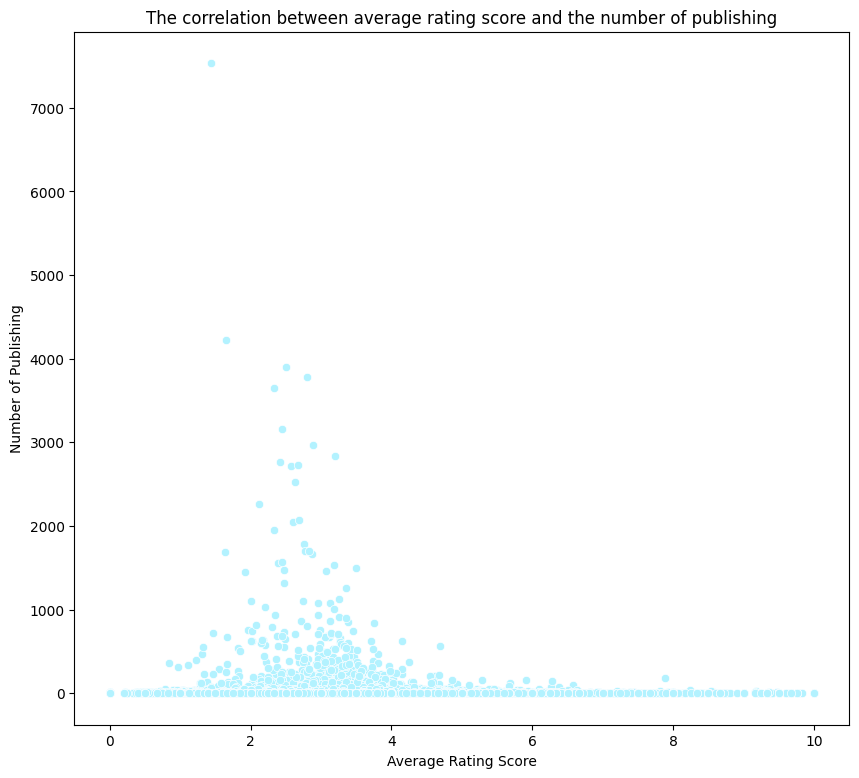

In [ ]:
# The correlation between the avg rating score and the number of publishing for each publisher
avg_rating_score = user.join(rating, 'User-ID', 'right').join(book, 'ISBN', 'left').\
  groupBy('Publisher').mean('Book-Rating')

n_of_publishing = book.groupBy('Publisher').count()

q17_2 = avg_rating_score.join(n_of_publishing, 'Publisher', 'inner').toPandas()[['avg(Book-Rating)', 'count']]

# visulization
plt.rcParams['figure.figsize'] = (10, 9)
s = sns.scatterplot(q17_2, x = 'avg(Book-Rating)', y = 'count', color = (0.7, 0.95, 1.0))
_ = s.set(title = 'The correlation between average rating score and the number of publishing',
          xlabel = 'Average Rating Score', ylabel = 'Number of Publishing')

# correlation
q17_2.corr()

Though it doesn't seems to be correlated, the publisher that is more productive seems to receive average scoring between 1.5 and 4.